In [1]:
import qiskit
import qiskit_ibm_runtime
print(f"Qiskit version: {qiskit.__version__}")
print(f"Runtime version: {qiskit_ibm_runtime.__version__}")

Qiskit version: 2.1.1
Runtime version: 0.41.0


## 6교시 : Primitive inputs and outputs



아래 회로와 같이 양자 회로를 만들어봅시다.

![](img/ex11.png)

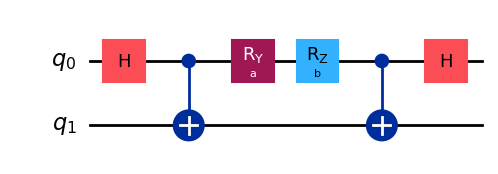

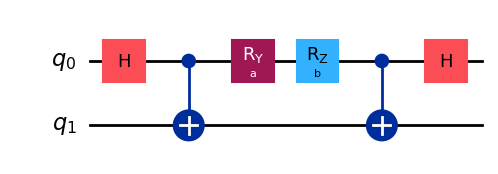

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

a = Parameter('a')
b = Parameter('b')

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)
qc.ry(a,0)
qc.rz(b,0)
qc.cx(0,1)
qc.h(0)

qc.draw('mpl')

Parameter에 들어갈 값을 지정합니다.

In [5]:
# "a" 와 "b" 의 값을 각각 100개씩 설정해줍니다.
import numpy as np

params = np.vstack(
    [
        np.linspace(-np.pi, np.pi, 100),
        np.linspace(-4 * np.pi, 4 * np.pi, 100),
    ]
).T
print(params)

[[ -3.14159265 -12.56637061]
 [ -3.07812614 -12.31250454]
 [ -3.01465962 -12.05863847]
 [ -2.9511931  -11.8047724 ]
 [ -2.88772658 -11.55090632]
 [ -2.82426006 -11.29704025]
 [ -2.76079354 -11.04317418]
 [ -2.69732703 -10.7893081 ]
 [ -2.63386051 -10.53544203]
 [ -2.57039399 -10.28157596]
 [ -2.50692747 -10.02770988]
 [ -2.44346095  -9.77384381]
 [ -2.37999443  -9.51997774]
 [ -2.31652792  -9.26611167]
 [ -2.2530614   -9.01224559]
 [ -2.18959488  -8.75837952]
 [ -2.12612836  -8.50451345]
 [ -2.06266184  -8.25064737]
 [ -1.99919533  -7.9967813 ]
 [ -1.93572881  -7.74291523]
 [ -1.87226229  -7.48904915]
 [ -1.80879577  -7.23518308]
 [ -1.74532925  -6.98131701]
 [ -1.68186273  -6.72745093]
 [ -1.61839622  -6.47358486]
 [ -1.5549297   -6.21971879]
 [ -1.49146318  -5.96585272]
 [ -1.42799666  -5.71198664]
 [ -1.36453014  -5.45812057]
 [ -1.30106362  -5.2042545 ]
 [ -1.23759711  -4.95038842]
 [ -1.17413059  -4.69652235]
 [ -1.11066407  -4.44265628]
 [ -1.04719755  -4.1887902 ]
 [ -0.98373103

In [22]:
# (3, 1) 행렬의 모양으로 3가지의 관측가능량을 정의해봅시다.
# XX, IY, 0.5 XX + 0.5 IY 입니다.
from qiskit.quantum_info import SparsePauliOp
observables = [
    [SparsePauliOp('XX')],
    [SparsePauliOp('IY')],
    [SparsePauliOp.from_list([('XX',0.5), ('IY',0.5)])]
]

이제 회로를 트랜스파일 해봅시다.

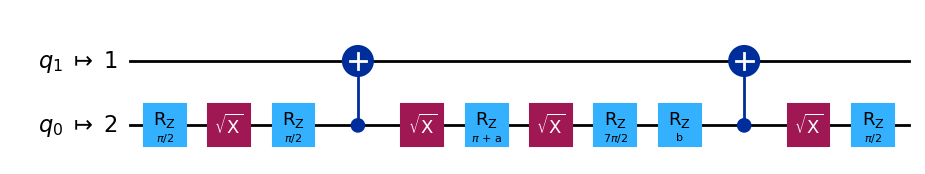

In [23]:
# 회로를 트랜스파일 해보세요.
#
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2

backend = FakeNairobiV2()
pm = generate_preset_pass_manager(backend=backend)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl')

In [24]:
# 트랜스파일한 회로에 맞게 관측가능량도 매핑을 해줘야 합니다.
observables = [
    [observable.apply_layout(isa_circuit.layout) for observable in observable_set]
    for observable_set in observables
]

이제 아래와 같이 pub을 구성하여 Estimator를 실행해보겠습니다.

In [15]:
from qiskit_ibm_runtime import Estimator
# 아래의 pub을 실행한 결괏값의 형태는 (3, 100)이 됩니다.
# 현재 파라미터의 형태가 (100, 2), 관측가능량의 형태가 (3, 1)이라는 것을 잘 기억해두세요.
estimator_pub = (isa_circuit, observables, params)

# estimator를 설정하여 실행합니다.
estimator = Estimator(mode=backend)
job = estimator.run([estimator_pub])
result = job.result()

실행한 결과를 같이 확인해볼까요?

In [17]:
#
np.shape(result[0].data.evs)

(3, 100)

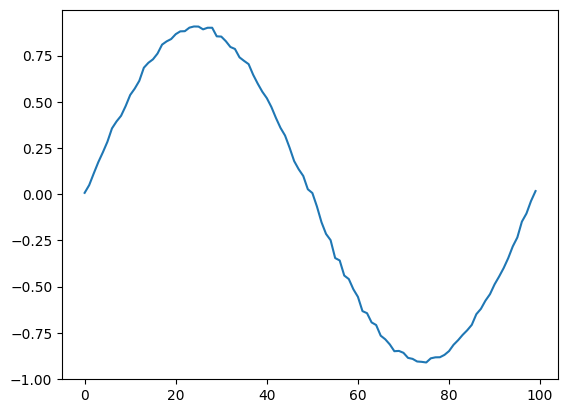

In [21]:
import matplotlib.pyplot as plt

plt.plot(result[0].data.evs[0])
plt.show()

### Broadcasting 규칙

PUB에 들어가는 변수들이 다양한 형태로 배열되어 있을 때 input을 구성하는 방식은 Numpy의 broadcasting 규칙을 따릅니다.자세한 설명은 [Qiskit 가이드](https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output)와 [NumPy broadcasting 규칙 문서](https://numpy.org/doc/stable/user/basics.broadcasting.html)를 참고하세요.

규칙:

*   입력값 배열은 서로 다른 차원과 크기를 가질 수 있습니다.
    *   결괏값의 배열은 입력값 배열의 각 차원에서 가장 큰 크기를 가져와 구성됩니다.
    *   누락된 차원이 있다면 해당 차원의 크기는 1로 가정합니다.
*   차원 크기는 가장 오른쪽(0차원)부터 순서대로 비교합니다.
*   두 배열의 각 차원의 크기는 서로 같거나 둘 중 하나가 1이어야 합니다.

broadcast 가능한 배열의 예시:

```text
A1     (1d array):      1
A2     (2d array):  3 x 5
Result (2d array):  3 x 5


A1     (3d array):  11 x 2 x 7
A2     (3d array):  11 x 1 x 7
Result (3d array):  11 x 2 x 7
```

broadcast가 되지 않는 배열의 예시:

```text
A1     (1d array):  5
A2     (1d array):  3

A1     (2d array):      2 x 1
A2     (3d array):  6 x 5 x 4 # 가운데 차원의 크기가 2였으면 broadcast가 가능했겠네요.
```

Qiskit primitive는 broadcast된 배열의 각 input을 가져와 결괏값을 계산합니다.

Broadcasting을 적용하는 주요 케이스에 대해 얘기해봅시다:

![This image illustrates several visual representations of array broadcasting](img/broadcasting.svg "Visual representation of broadcasting")



In [18]:
# Broadcast single observable
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = SparsePauliOp("ZZZ")  # shape ()
# >> pub result has shape (5,)

# Zip
parameter_values = np.random.uniform(size=(5,))  # shape (5,)
observables = [
    SparsePauliOp(pauli) for pauli in ["III", "XXX", "YYY", "ZZZ", "XYZ"]
]  # shape (5,)
# >> pub result has shape (5,)

# Outer/Product
parameter_values = np.random.uniform(size=(1, 6))  # shape (1, 6)
observables = [
    [SparsePauliOp(pauli)] for pauli in ["III", "XXX", "YYY", "ZZZ"]
]  # shape (4, 1)
# >> pub result has shape (4, 6)

# Standard nd generalization
parameter_values = np.random.uniform(size=(3, 6))  # shape (3, 6)
observables = [
    [
        [SparsePauliOp(["XII"])],
        [SparsePauliOp(["IXI"])],
        [SparsePauliOp(["IIX"])],
    ],
    [
        [SparsePauliOp(["ZII"])],
        [SparsePauliOp(["IZI"])],
        [SparsePauliOp(["IIZ"])],
    ],
]
# >> pub result has shape (2, 3, 1)

위에서 주어진 케이스를 실행해보고 앞에서와 같이 그래프로 나타내봅시다.

In [ ]:
#